In [1]:
import sys
sys.path.append('..')

from utils.common import read_beacon_coords, read_beacon_data, process_beacon_data_for_strongthree, process_beacon_data_for_pos
import argparse
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import pdb
# visualize the beacon RSSI to distance
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import pdb
from scipy.signal import medfilt
from filterpy.kalman import KalmanFilter

[[{'uuid': '88400000-0000-0000-0000-000000000000', 'rssi': -73, 'accuracy': 60.184995180183634, 'time': 1725516541537}], [{'uuid': '88400000-0000-0000-0000-000000000000', 'rssi': -64, 'accuracy': 16.658868643737616, 'time': 1725516541637}, {'uuid': '1a040000-0000-0000-0000-000000000000', 'rssi': -68, 'accuracy': 29.992573490350974, 'time': 1725516541637}], [{'uuid': '88400000-0000-0000-0000-000000000000', 'rssi': -64, 'accuracy': 16.658868643737616, 'time': 1725516541738}, {'uuid': '1a040000-0000-0000-0000-000000000000', 'rssi': -68, 'accuracy': 29.992573490350974, 'time': 1725516541738}], [{'uuid': '88400000-0000-0000-0000-000000000000', 'rssi': -60, 'accuracy': 9.027046541095386, 'time': 1725516541837}, {'uuid': '1a040000-0000-0000-0000-000000000000', 'rssi': -68, 'accuracy': 29.992573490350974, 'time': 1725516541837}, {'uuid': '0f3c0000-0000-0000-0000-000000000000', 'rssi': -64, 'accuracy': 16.658868643737616, 'time': 1725516541837}], [{'uuid': '88400000-0000-0000-0000-000000000000'

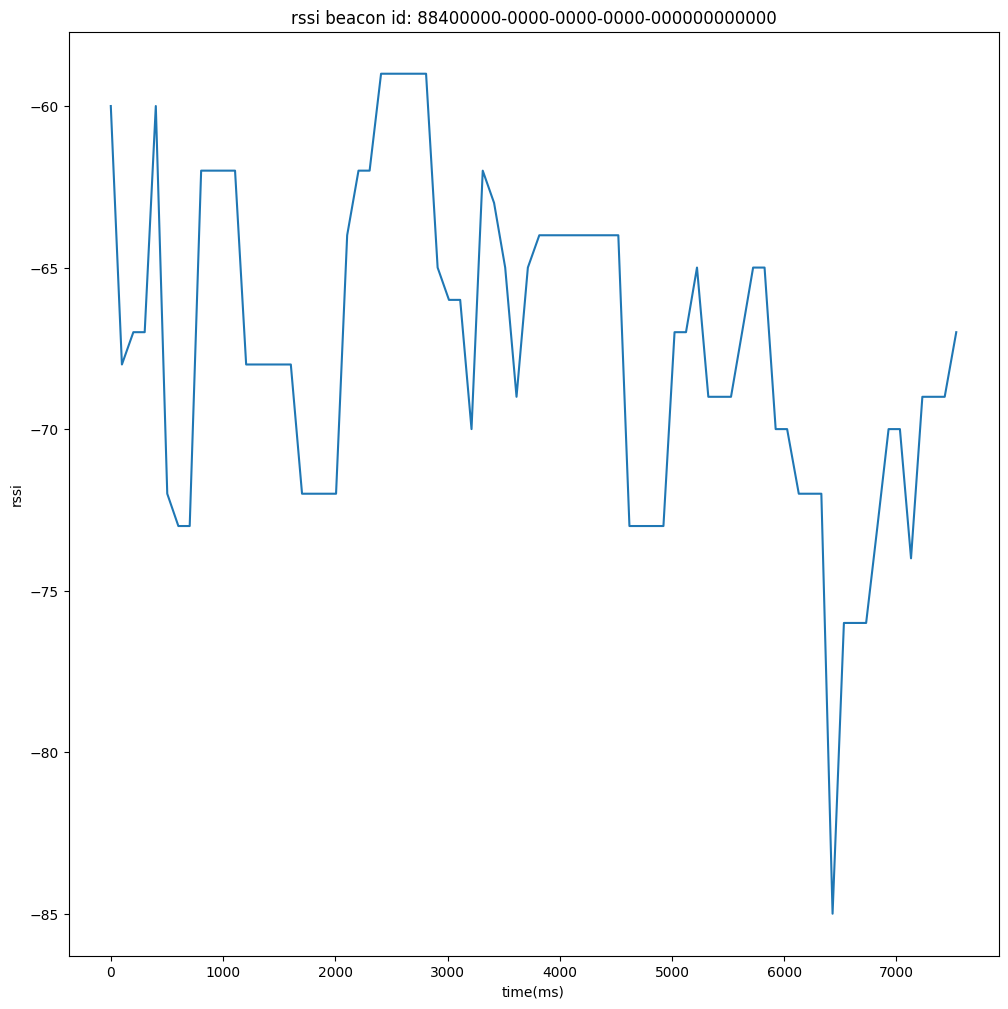

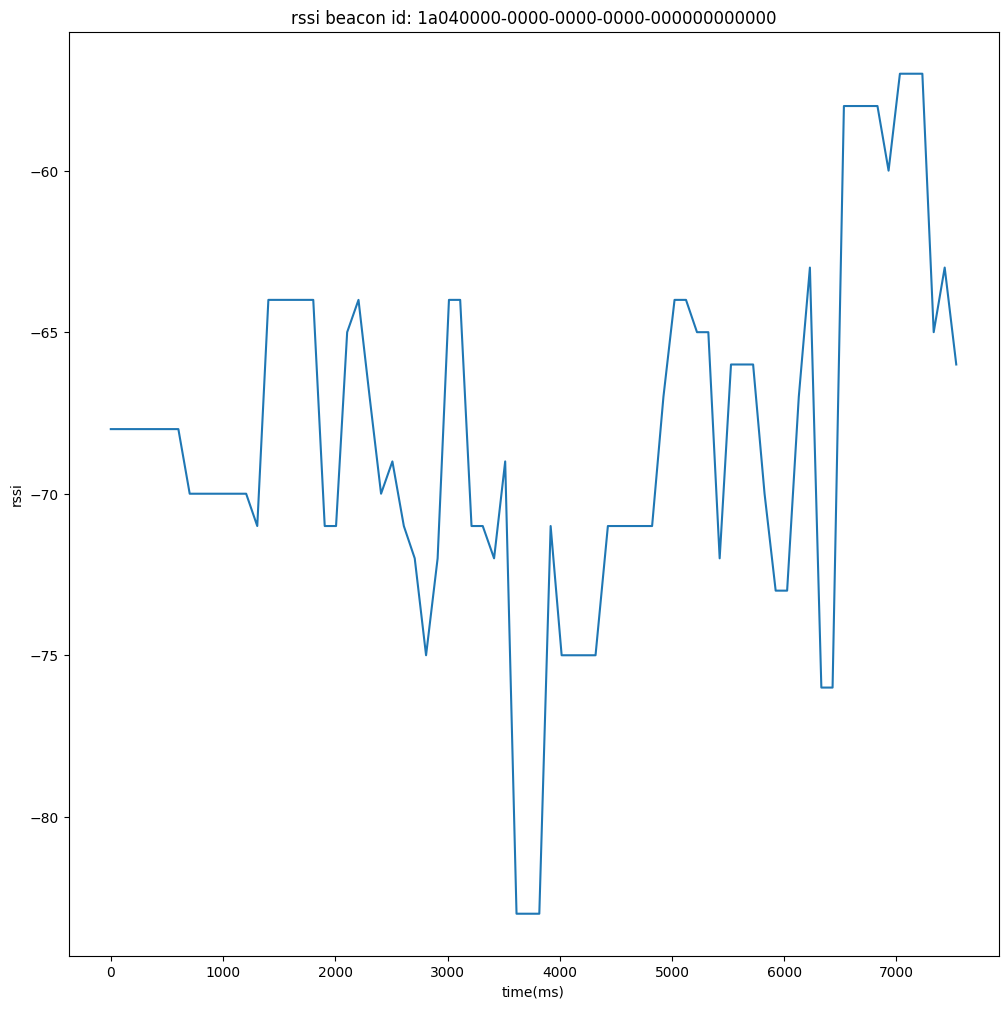

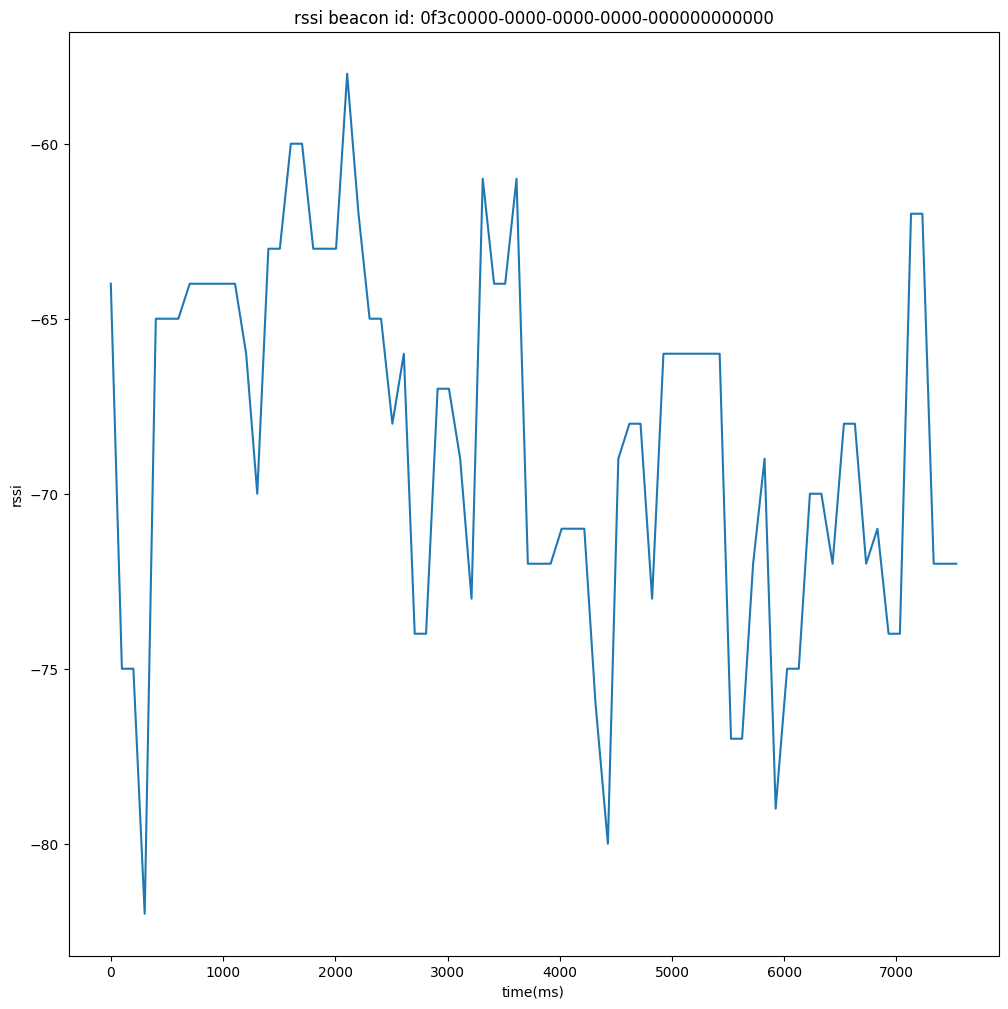

In [2]:

args = argparse.Namespace(beacon_coords_file='../datas/data0905p4/beacon_coords.txt', beacon_data_dir='../datas/data0905p4/', beacon_data_file='../datas/data0905p4/bluetoothData(101).txt', update_frequency=10)

beacon_data = read_beacon_data(args.beacon_data_file)

def remove_outliers(data, threshold=0.5):
    mean = np.mean(data)
    std = np.std(data)
    return [x if abs(x - mean) <= threshold * std else mean for x in data]

def remove_max_min(data):
    sorted_data = sorted(data)
    max_data = sorted_data[-2:]
    min_data = sorted_data[:2]
    mean = np.mean(sorted_data)
    return [x if x not in max_data and x not in min_data else mean for x in data]

def apply_average_filter(data, remove_f, window_size=5):
    filtered_data = data.copy()
    for i in range(len(filtered_data)-window_size+1):
        trimmed_data = remove_f(filtered_data[i:i+window_size])
        filtered_data[i+window_size//2] = np.mean(trimmed_data)
    return filtered_data

def apply_median_filter(data, remove_f, window_size=5):
    filtered_data = data.copy()
    for i in range(len(filtered_data)-window_size+1):
        trimmed_data = remove_f(filtered_data[i:i+window_size])
        filtered_data[i+window_size//2] = np.median(trimmed_data)
    return filtered_data

def apply_kalman_filter(data):
    # data = remove_outliers(data)
    kf = KalmanFilter(dim_x=1, dim_z=1)
    kf.x = np.array([data[0]])
    kf.P *= 1000.
    kf.R = 5
    kf.Q = 0.1
    kf.H = np.array([[1.]])
    kf.F = np.array([[1.]])
    
    filtered_data = []
    for measurement in data:
        kf.predict()
        kf.update(measurement)
        filtered_data.append(kf.x[0])
    return filtered_data

def rssi_to_distance(rssi):
    txPower = -55.47
    n = 3.106
    return 10 ** ((txPower - rssi) / (10 * n))



x0, y0 = 3.0, -1.6
v = 0.00056


beacon_id_to_rssi = defaultdict(list)
time_stamp = []
print(beacon_data)
for beacon_group in beacon_data:
    if len(beacon_group) < 3:
        print("beacon group length is less than 3")
        continue
    for beacon in beacon_group:
        beacon_id = beacon['uuid']
        beacon_id_to_rssi[beacon_id].append(beacon['rssi'])
    time_stamp.append(beacon['time'])

time_stamp = np.array(time_stamp) - time_stamp[0]
total_interval = time_stamp[-1] - time_stamp[0]
d1 = np.sqrt(x0**2 + (y0 + v * time_stamp)**2 + 1.0)
d2 = np.sqrt(x0**2 + (6.0 -y0 - v * time_stamp)**2 + 1.0)
d3 = np.sqrt((x0 - 6.0)**2 + (3 - y0 - v * time_stamp)**2 + 1.0)
ds = [d1, d2, d3]
print("total time interval: ", time_stamp[-1] - time_stamp[0])
for i, (beacon_id, rssi_values) in enumerate(beacon_id_to_rssi.items()):
    if len(beacon_group[0]) <= 3:
        print("beacon group length is less than 3")
        continue
    plt.figure(figsize=(12, 12))
    plt.plot(time_stamp, rssi_values)
    plt.xlabel('time(ms)')
    plt.ylabel('rssi')
    plt.title('rssi beacon id: {}'.format(beacon_id))
    plt.show()
    
    # distance = [rssi_to_distance(rssi) for rssi in rssi_values]
    # rssi_median_filtered = apply_median_filter(rssi_values, remove_max_min)
    # rssi_kalman_filtered = apply_kalman_filter(rssi_values)
    # rssi_mean_filtered = apply_average_filter(rssi_values, remove_max_min)
    # plt.figure(figsize=(12, 12))
    # plt.plot(time_stamp, rssi_values, label='rssi')
    # plt.plot(time_stamp, rssi_median_filtered, label='rssi median filter')
    # plt.plot(time_stamp, rssi_kalman_filtered, label='rssi kalman filter')
    # plt.plot(time_stamp, rssi_mean_filtered, label='rssi mean filter')
    # # plt.plot(time_stamp, d, label='real distance')
    # plt.xlabel('time(ms)')
    # plt.ylabel('rssi')
    # plt.legend()
    # plt.title('rssi filtered beacon id: {}'.format(beacon_id))
    # plt.show()
    
    # rssi_median_filtered = apply_median_filter(rssi_values, remove_outliers)
    # rssi_mean_filtered = apply_average_filter(rssi_values, remove_outliers)
    # rssi_kalman_filtered = apply_kalman_filter(rssi_values) 
    # plt.figure(figsize=(12, 12))
    # plt.plot(time_stamp, rssi_values, label='rssi')
    # plt.plot(time_stamp, rssi_median_filtered, label='rssi median filter')
    # plt.plot(time_stamp, rssi_kalman_filtered, label='rssi kalman filter')
    # plt.plot(time_stamp, rssi_mean_filtered, label='rssi mean filter')
    # # plt.plot(time_stamp, d, label='real distance')
    # plt.xlabel('time(ms)')
    # plt.ylabel('rssi')
    # plt.legend()
    # plt.title('rssi filtered beacon id: {}, use std-mean trim method'.format(beacon_id))
    # plt.show() 
    
    
    # distance_median_filtered = [rssi_to_distance(rssi) for rssi in rssi_median_filtered]
    # distance_kalman_filtered = [rssi_to_distance(rssi) for rssi in rssi_kalman_filtered]
    # distance_mean_filtered = [rssi_to_distance(rssi) for rssi in rssi_mean_filtered]
    # plt.figure(figsize=(12, 12))
    # plt.plot(time_stamp, distance, label='rssi to distance')
    # plt.plot(time_stamp, distance_median_filtered, label='distance median filter')
    # plt.plot(time_stamp, distance_kalman_filtered, label='distance kalman filter')
    # plt.plot(time_stamp, distance_mean_filtered, label='distance mean filter')
    # # plt.plot(time_stamp, ds[i], label='real distance')
    # plt.xlabel('time(ms)')
    # plt.ylabel('distance(m)')
    # plt.title('distance filtered beacon id: {}'.format(beacon_id))
    # plt.legend()
    # plt.show()


In [3]:
from utils.common import aggregate_continuous_points_sliding, aggregate_continuous_points
import re


args = argparse.Namespace(beacon_coords_file='../datas/data0905p4/beacon_coords.txt', beacon_data_dir='../datas/data0905p4/', beacon_data_file='', update_frequency=10)

files = []
for file in os.listdir(args.beacon_data_dir):
    if re.match(r'bluetoothData\(\d+\).txt', file):
        files.append(file)

positionss = []
for beacon_data_file in files:
    args.beacon_data_file = args.beacon_data_dir + beacon_data_file
    actual_coords = read_beacon_coords(args.beacon_coords_file)
    beacon_data = read_beacon_data(args.beacon_data_file)
    print("beacon data",beacon_data)
    print("beacon group num", len(beacon_data))
    print("beacon data file", args.beacon_data_file)

    positions = process_beacon_data_for_pos(args)
    positions = [pos[:3] for pos in positions if pos is not None]
    positionss.append(positions)

beacon data [[{'uuid': '88400000-0000-0000-0000-000000000000', 'rssi': -72, 'accuracy': 52.538987674951514, 'time': 1725516667705}, {'uuid': '0f3c0000-0000-0000-0000-000000000000', 'rssi': -69, 'accuracy': 34.59438414037775, 'time': 1725516667705}], [{'uuid': '88400000-0000-0000-0000-000000000000', 'rssi': -73, 'accuracy': 60.184995180183634, 'time': 1725516667801}, {'uuid': '0f3c0000-0000-0000-0000-000000000000', 'rssi': -69, 'accuracy': 34.59438414037775, 'time': 1725516667801}], [{'uuid': '88400000-0000-0000-0000-000000000000', 'rssi': -67, 'accuracy': 25.958067100628753, 'time': 1725516667913}, {'uuid': '1a040000-0000-0000-0000-000000000000', 'rssi': -74, 'accuracy': 68.82791240399628, 'time': 1725516667913}, {'uuid': '0f3c0000-0000-0000-0000-000000000000', 'rssi': -63, 'accuracy': 14.323008481499683, 'time': 1725516667913}], [{'uuid': '88400000-0000-0000-0000-000000000000', 'rssi': -67, 'accuracy': 25.958067100628753, 'time': 1725516668004}, {'uuid': '1a040000-0000-0000-0000-00000

len positions 89
positions [array([[2.64293841],
       [2.45330798],
       [0.81891899]]), array([[2.78093176],
       [2.58140033],
       [0.86167646]]), array([[2.8208003 ],
       [2.61569157],
       [0.88121236]]), array([[2.92184458],
       [2.74311888],
       [0.89336945]]), array([[2.58300839],
       [2.99141324],
       [0.90073658]]), array([[2.50554385],
       [3.29139848],
       [0.90479498]]), array([[2.3424618 ],
       [3.34434737],
       [0.90677025]]), array([[2.40348859],
       [3.28382168],
       [0.90757043]]), array([[2.41594236],
       [3.28186184],
       [0.90768624]]), array([[2.71015077],
       [3.67341729],
       [0.90745825]]), array([[2.68140768],
       [3.47869993],
       [0.90705364]]), array([[2.62832225],
       [3.33769437],
       [0.90657224]]), array([[2.69675553],
       [3.4684586 ],
       [0.90606261]]), array([[2.32982622],
       [3.23924391],
       [0.90555656]]), array([[2.36105479],
       [3.18889998],
       [0.90507007]]

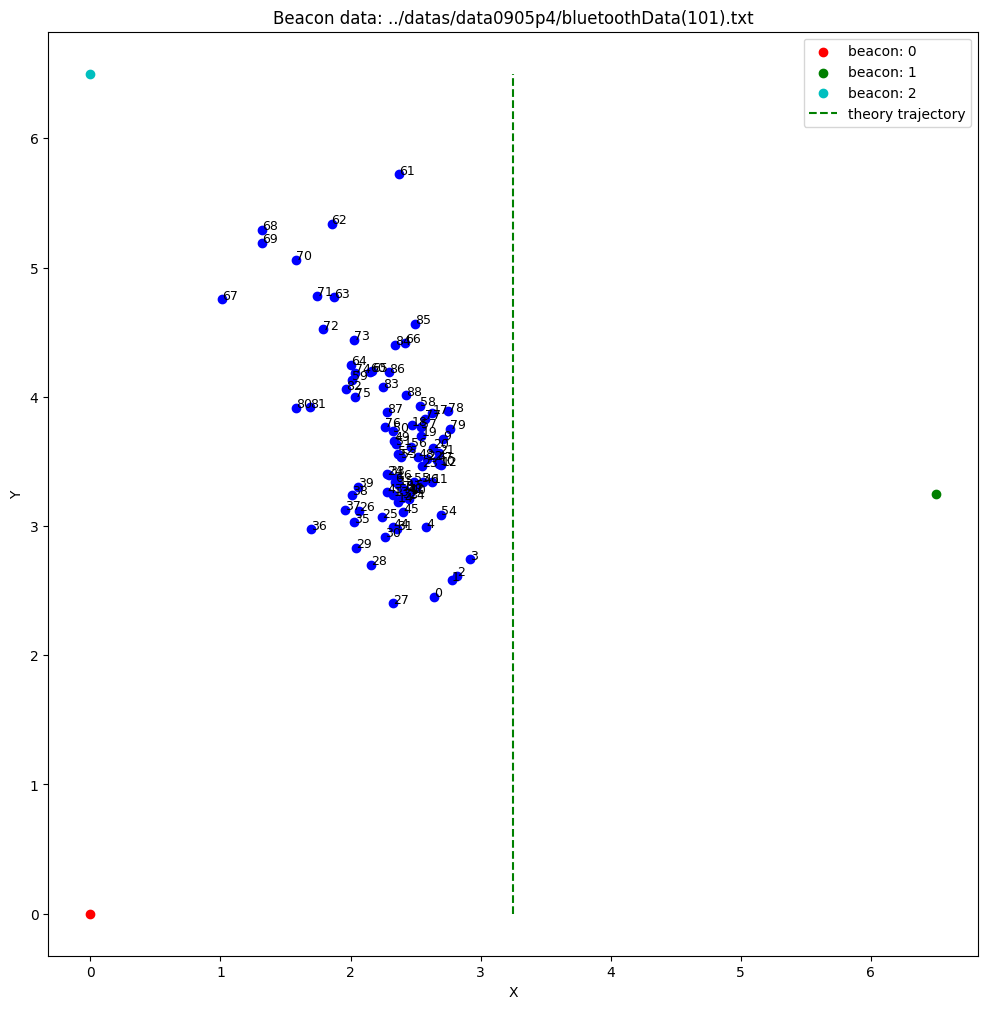

positions [array([[2.64293841],
       [2.45330798],
       [0.81891899]]), array([[2.78093176],
       [2.58140033],
       [0.86167646]]), array([[2.8208003 ],
       [2.61569157],
       [0.88121236]]), array([[2.92184458],
       [2.74311888],
       [0.89336945]]), array([[2.58300839],
       [2.99141324],
       [0.90073658]]), array([[2.50554385],
       [3.29139848],
       [0.90479498]]), array([[2.3424618 ],
       [3.34434737],
       [0.90677025]]), array([[2.40348859],
       [3.28382168],
       [0.90757043]]), array([[2.41594236],
       [3.28186184],
       [0.90768624]]), array([[2.71015077],
       [3.67341729],
       [0.90745825]]), array([[2.68140768],
       [3.47869993],
       [0.90705364]]), array([[2.62832225],
       [3.33769437],
       [0.90657224]]), array([[2.69675553],
       [3.4684586 ],
       [0.90606261]]), array([[2.32982622],
       [3.23924391],
       [0.90555656]]), array([[2.36105479],
       [3.18889998],
       [0.90507007]]), array([[2.3693

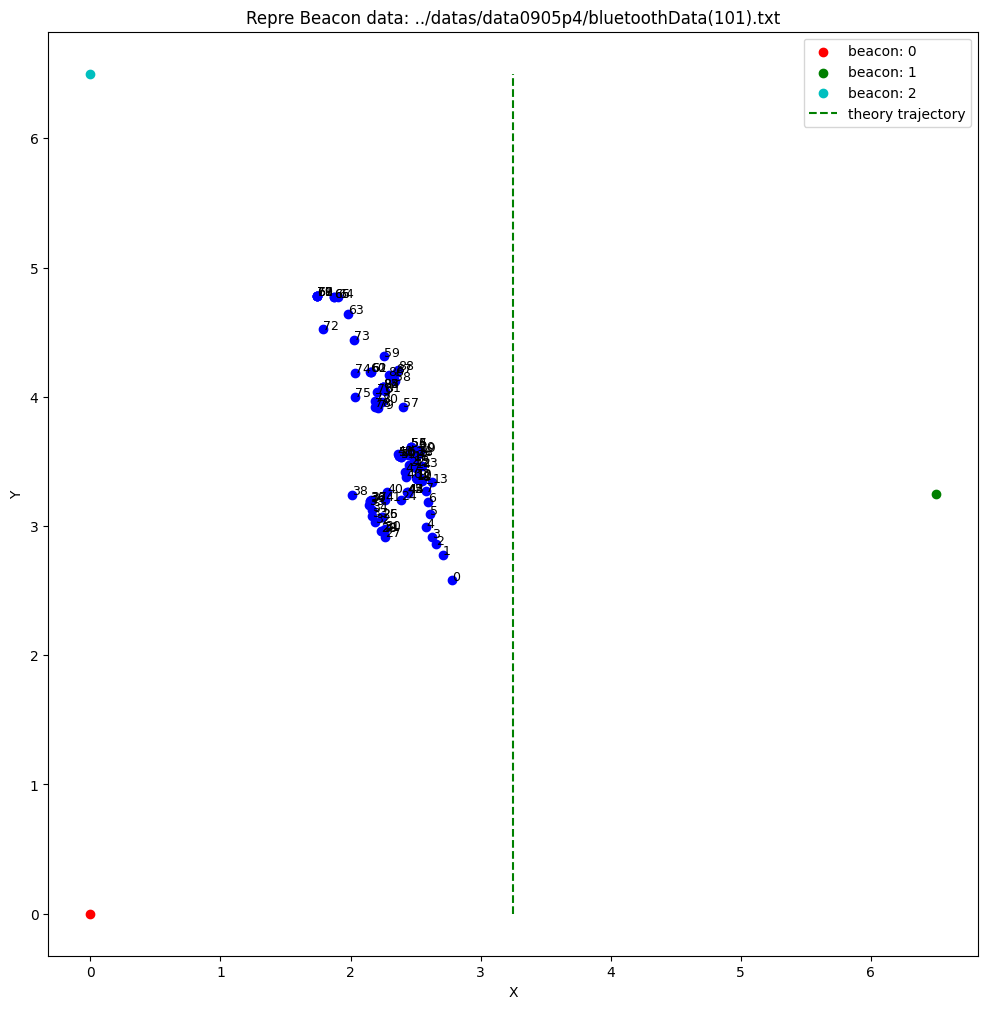

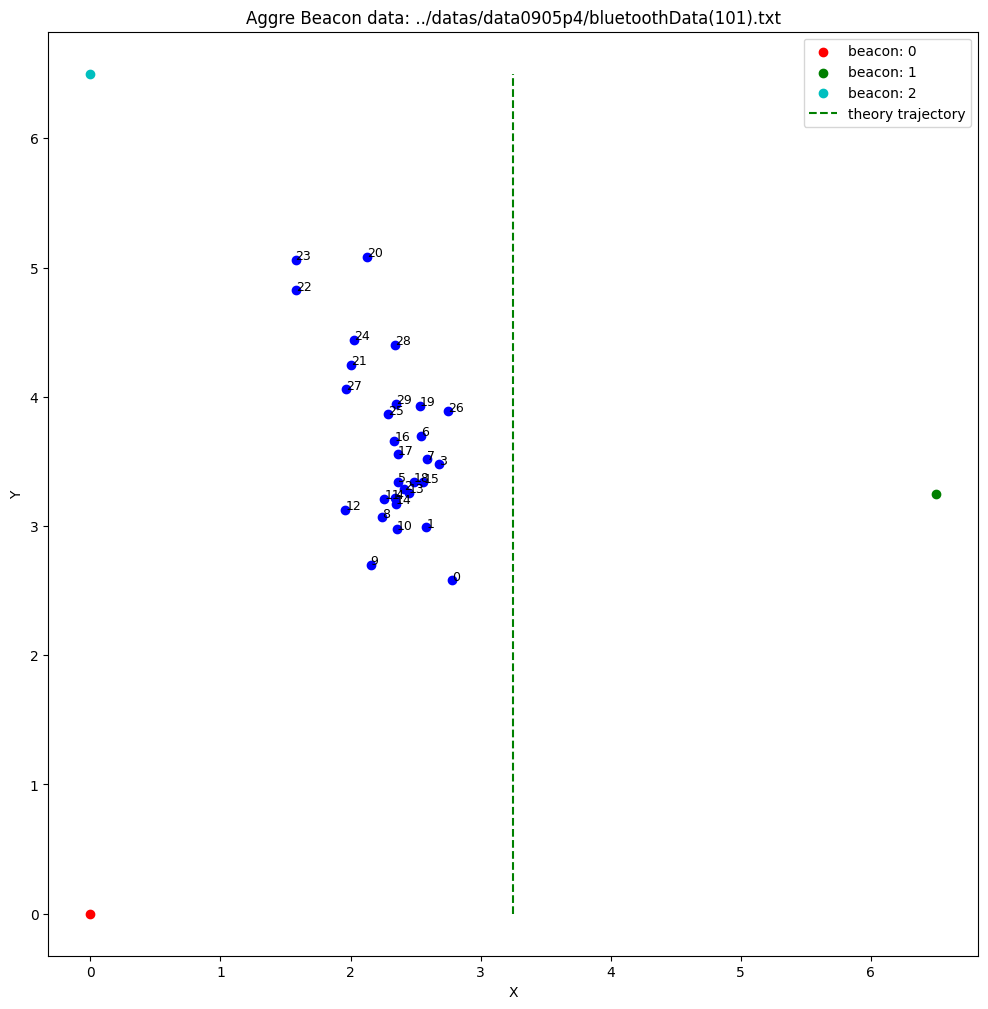

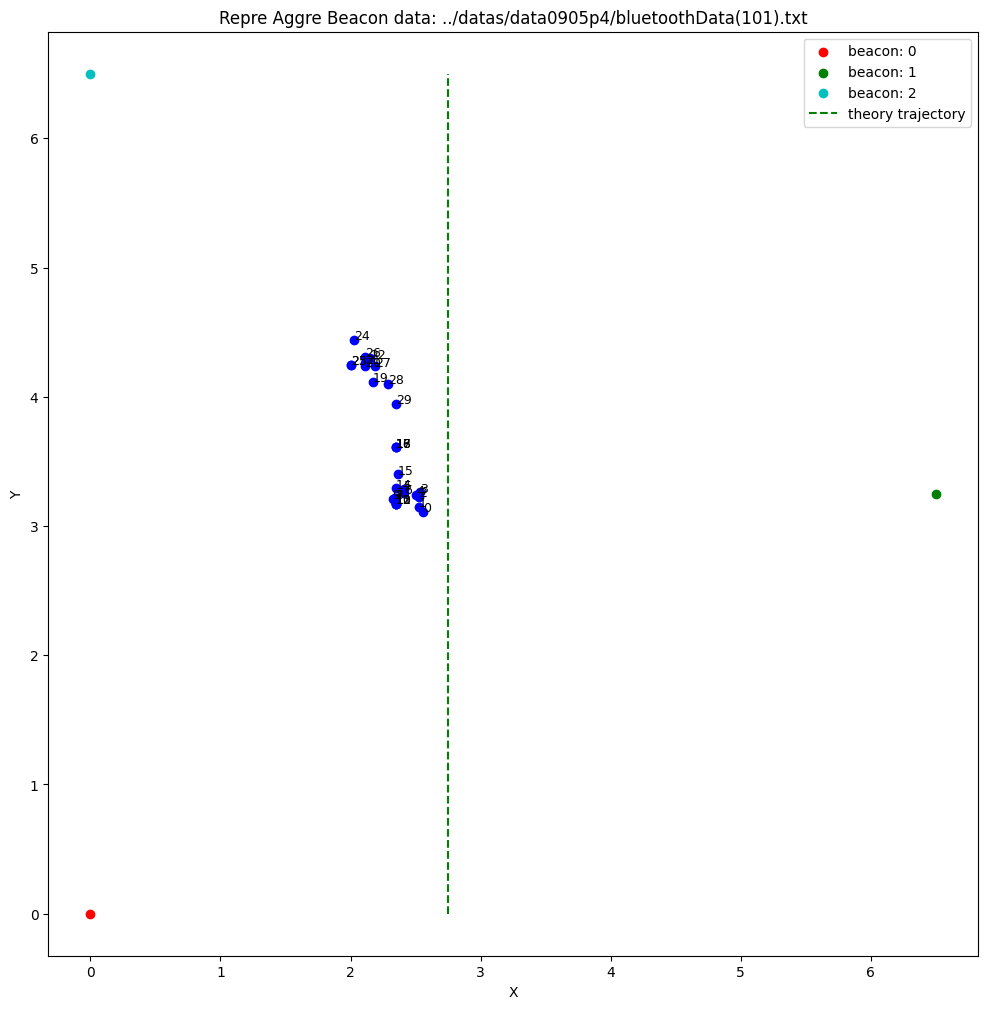

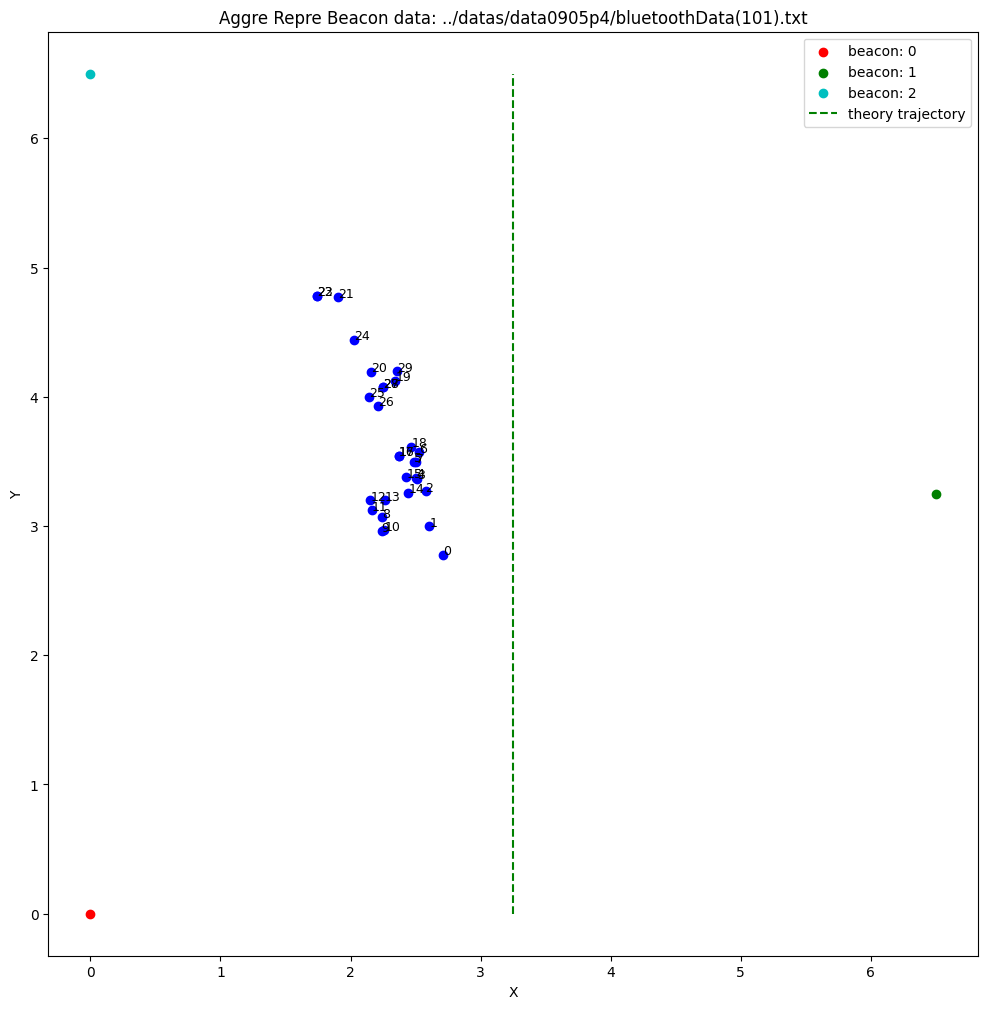

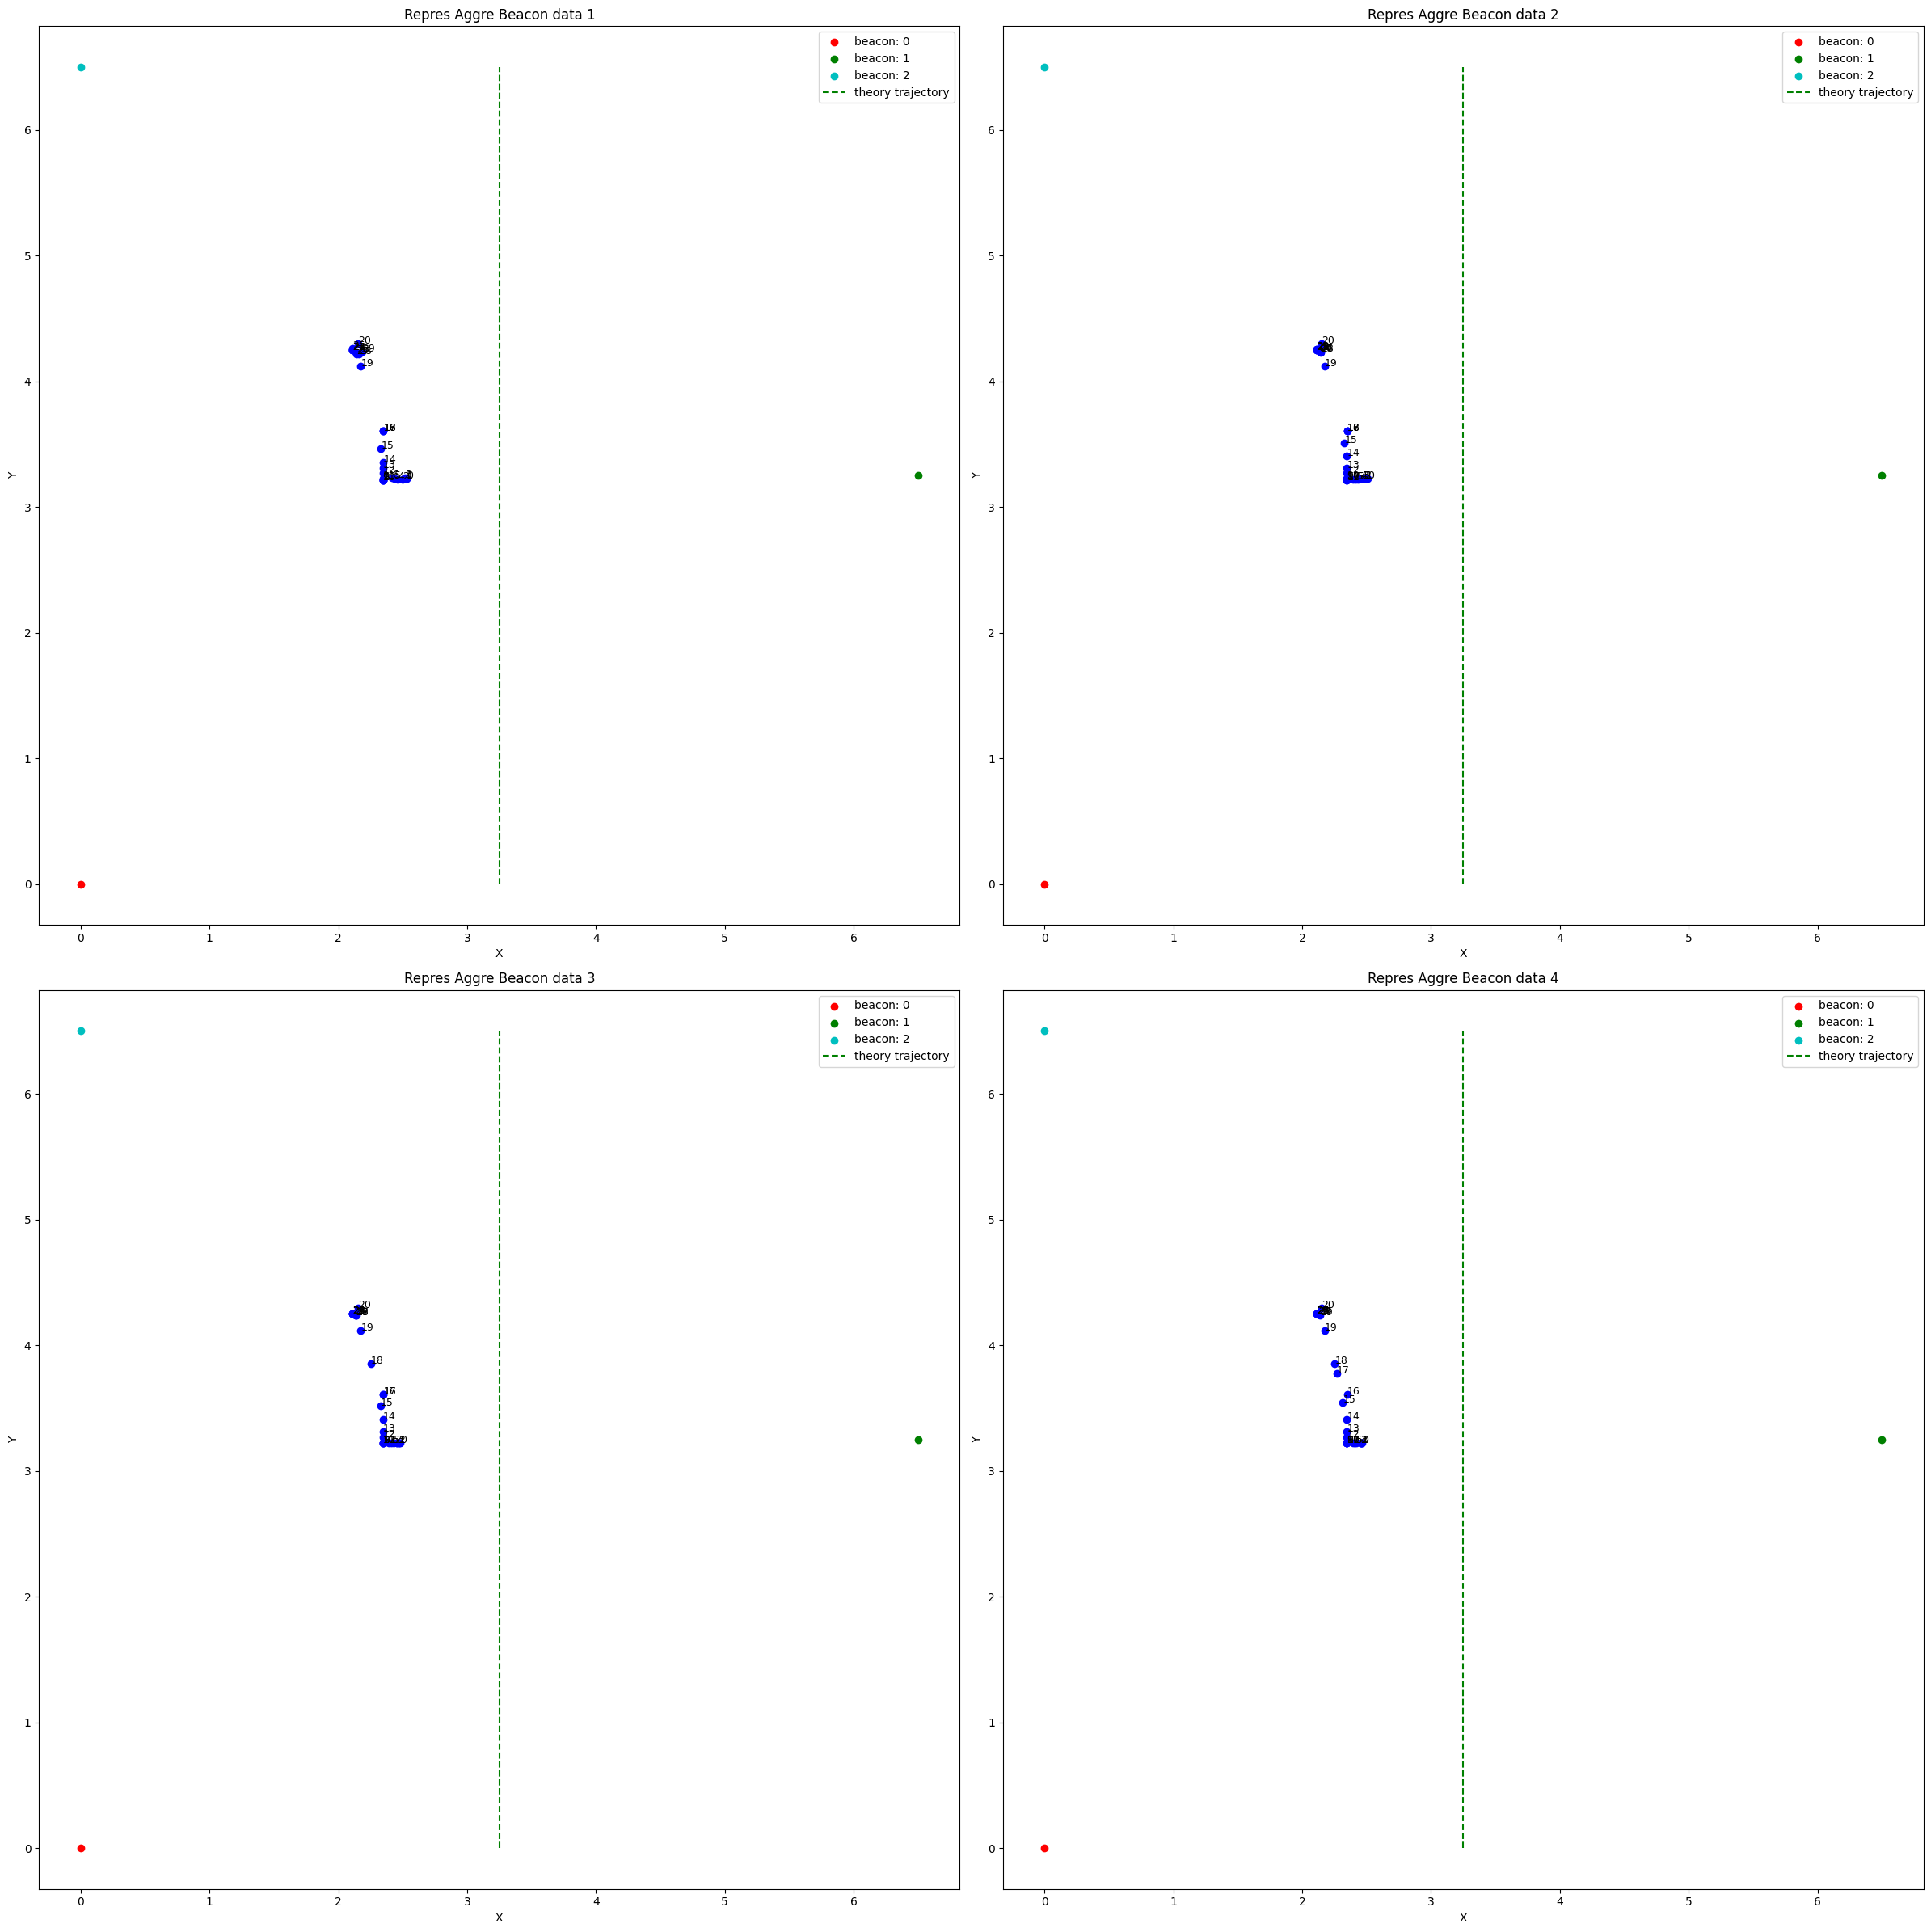

len positions 76
positions [array([[2.06662195],
       [2.6127359 ],
       [0.81891898]]), array([[1.78151804],
       [2.94855968],
       [0.86166825]]), array([[1.63492103],
       [3.06746685],
       [0.88120173]]), array([[0.88173606],
       [3.13733811],
       [0.89336392]]), array([[1.36793561],
       [3.0445908 ],
       [0.90073303]]), array([[1.92966203],
       [3.28536185],
       [0.90477967]]), array([[2.32969359],
       [3.48276291],
       [0.90676354]]), array([[2.66079347],
       [3.54607415],
       [0.90755053]]), array([[2.65188953],
       [3.29600431],
       [0.90767657]]), array([[2.6371125 ],
       [3.12522638],
       [0.90745268]]), array([[2.62009012],
       [3.00863406],
       [0.90705267]]), array([[2.60258338],
       [2.92906871],
       [0.90656974]]), array([[2.6286767 ],
       [2.98391132],
       [0.90606504]]), array([[2.54656663],
       [2.98577271],
       [0.90556047]]), array([[2.55017719],
       [3.15195041],
       [0.90507408]]

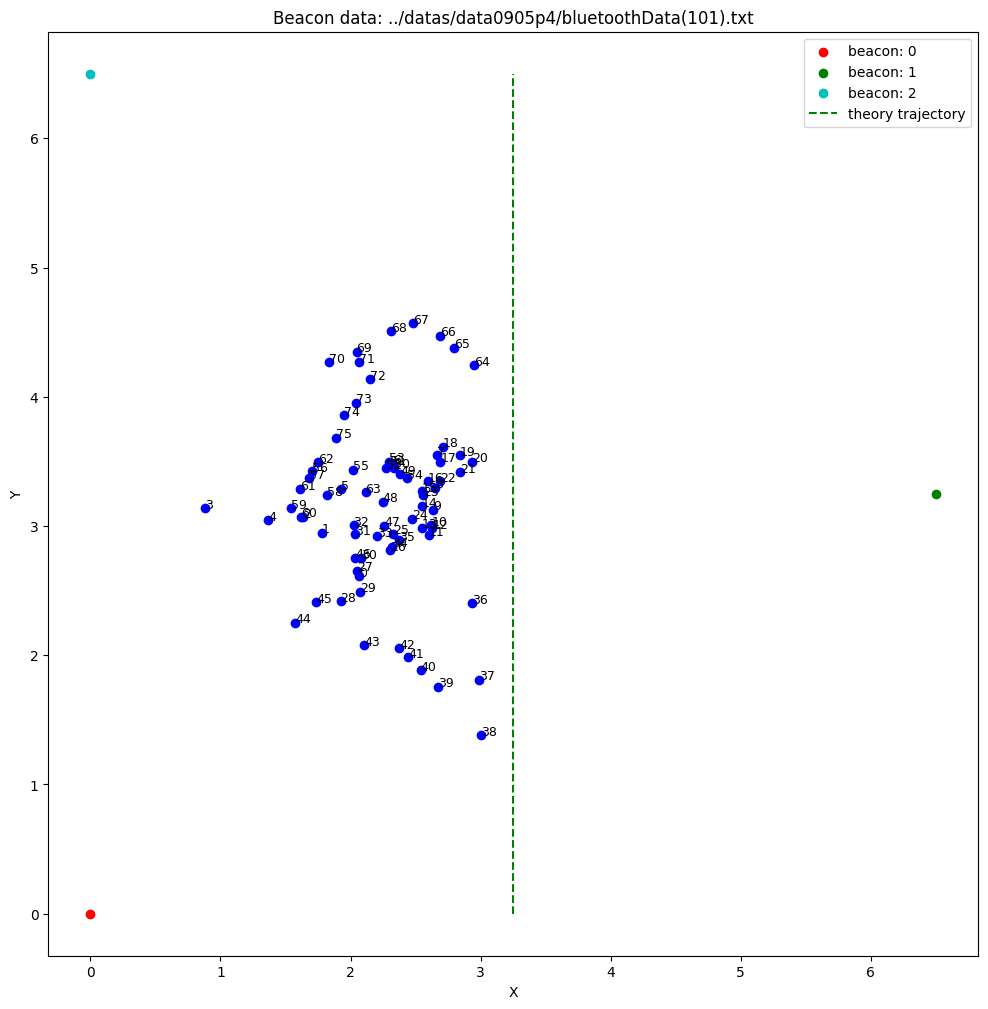

positions [array([[2.06662195],
       [2.6127359 ],
       [0.81891898]]), array([[1.78151804],
       [2.94855968],
       [0.86166825]]), array([[1.63492103],
       [3.06746685],
       [0.88120173]]), array([[0.88173606],
       [3.13733811],
       [0.89336392]]), array([[1.36793561],
       [3.0445908 ],
       [0.90073303]]), array([[1.92966203],
       [3.28536185],
       [0.90477967]]), array([[2.32969359],
       [3.48276291],
       [0.90676354]]), array([[2.66079347],
       [3.54607415],
       [0.90755053]]), array([[2.65188953],
       [3.29600431],
       [0.90767657]]), array([[2.6371125 ],
       [3.12522638],
       [0.90745268]]), array([[2.62009012],
       [3.00863406],
       [0.90705267]]), array([[2.60258338],
       [2.92906871],
       [0.90656974]]), array([[2.6286767 ],
       [2.98391132],
       [0.90606504]]), array([[2.54656663],
       [2.98577271],
       [0.90556047]]), array([[2.55017719],
       [3.15195041],
       [0.90507408]]), array([[2.5495

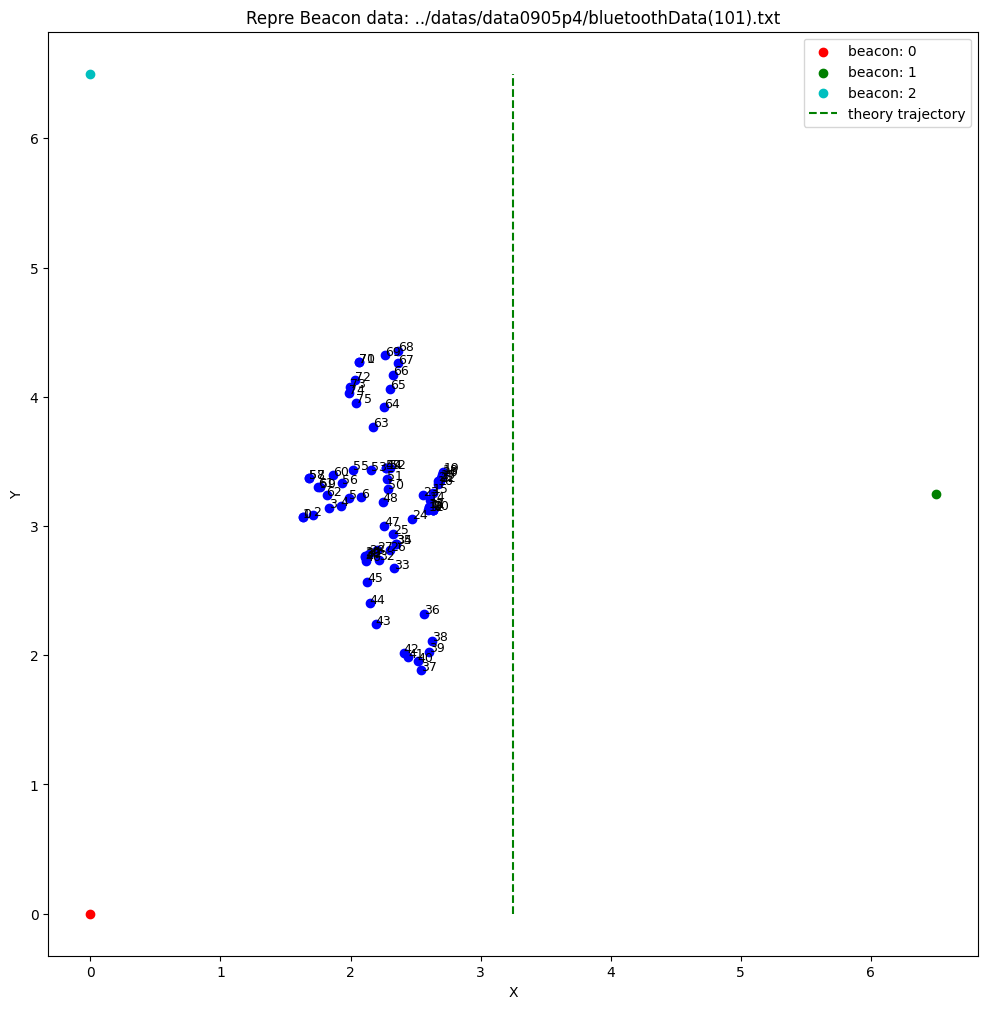

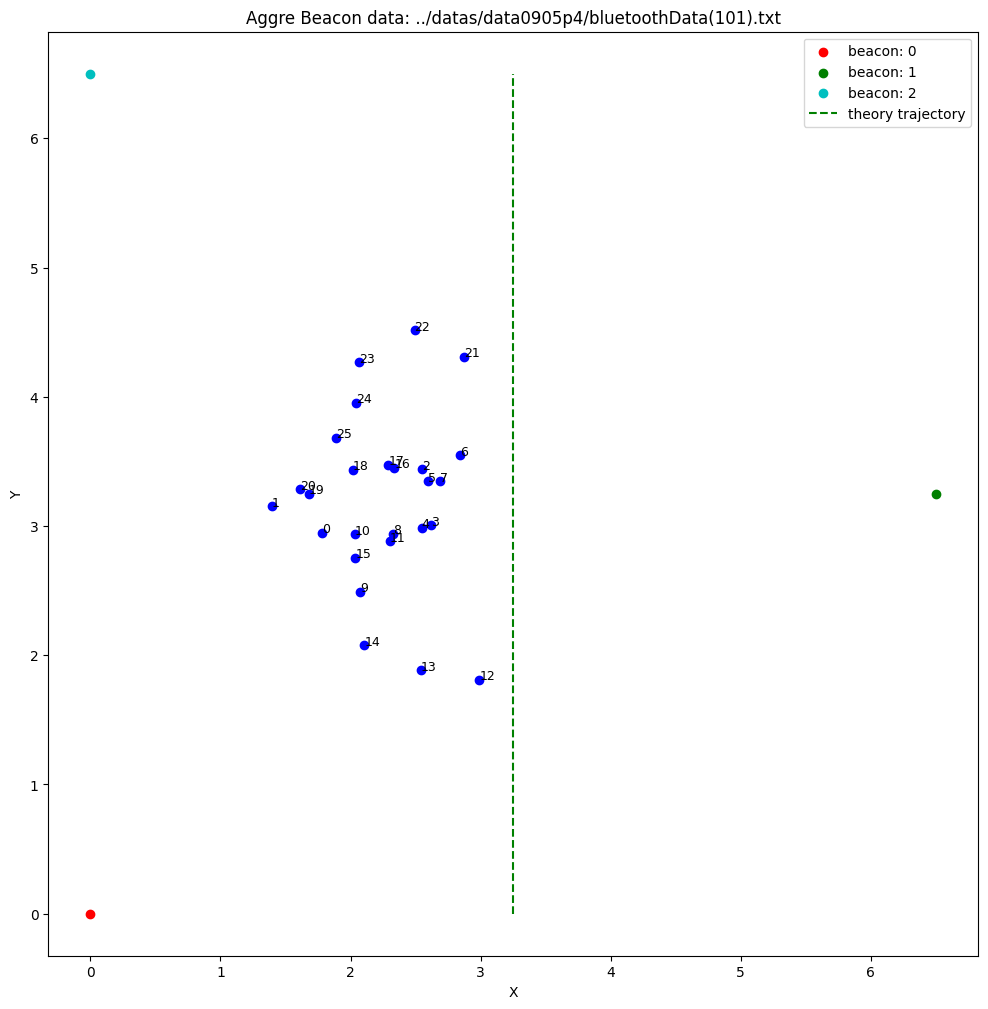

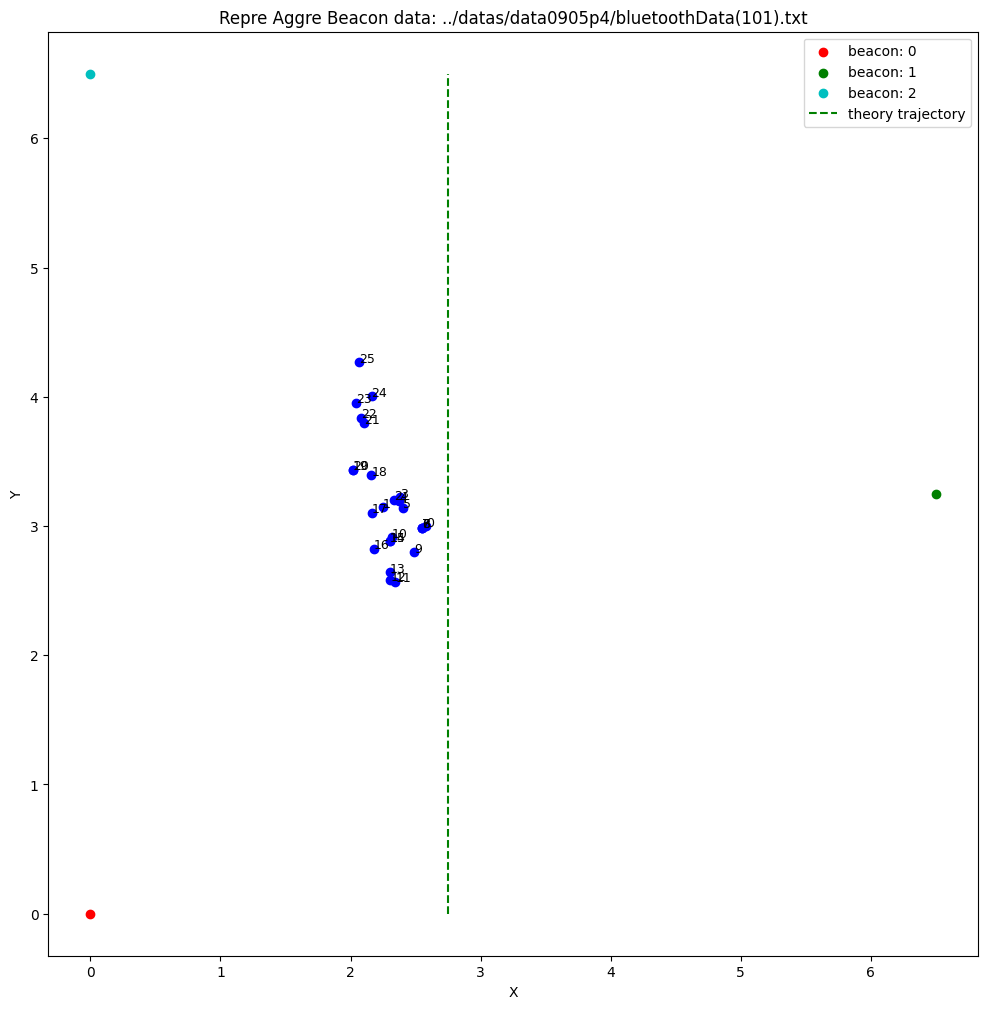

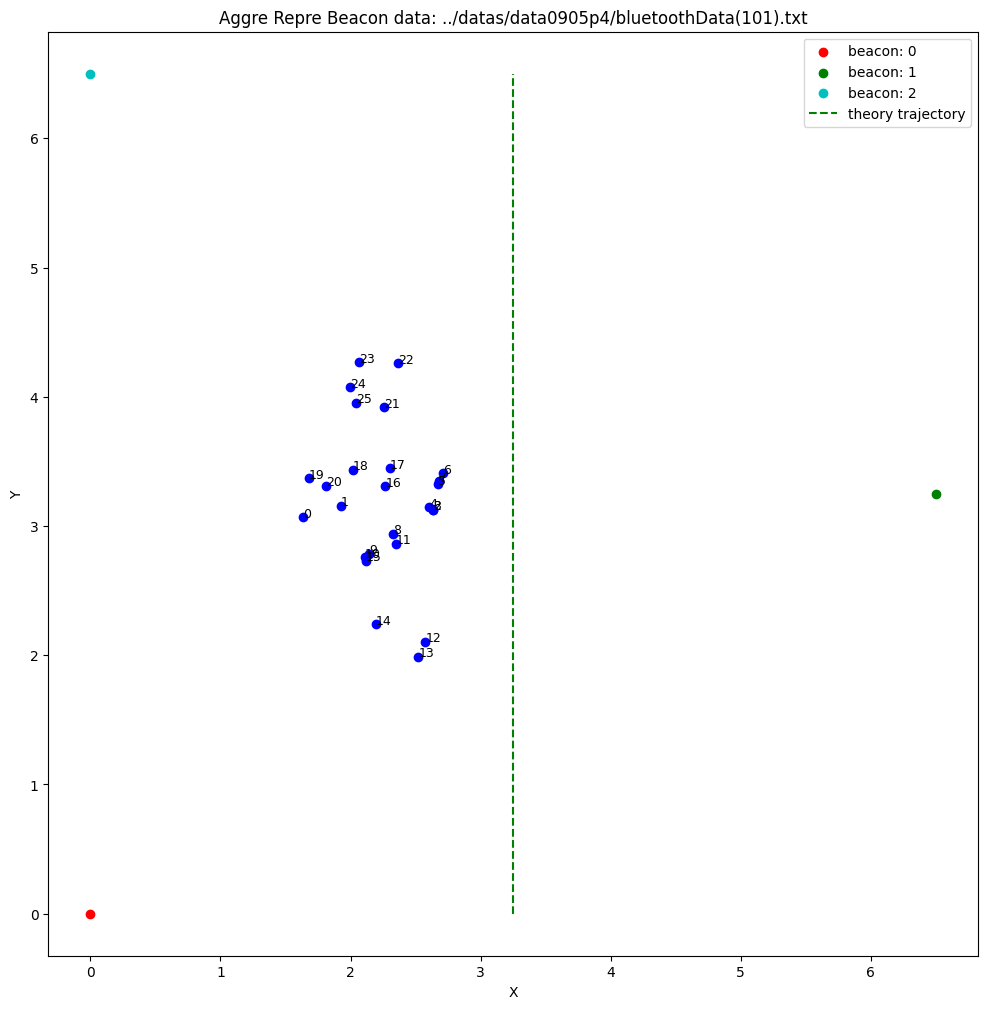

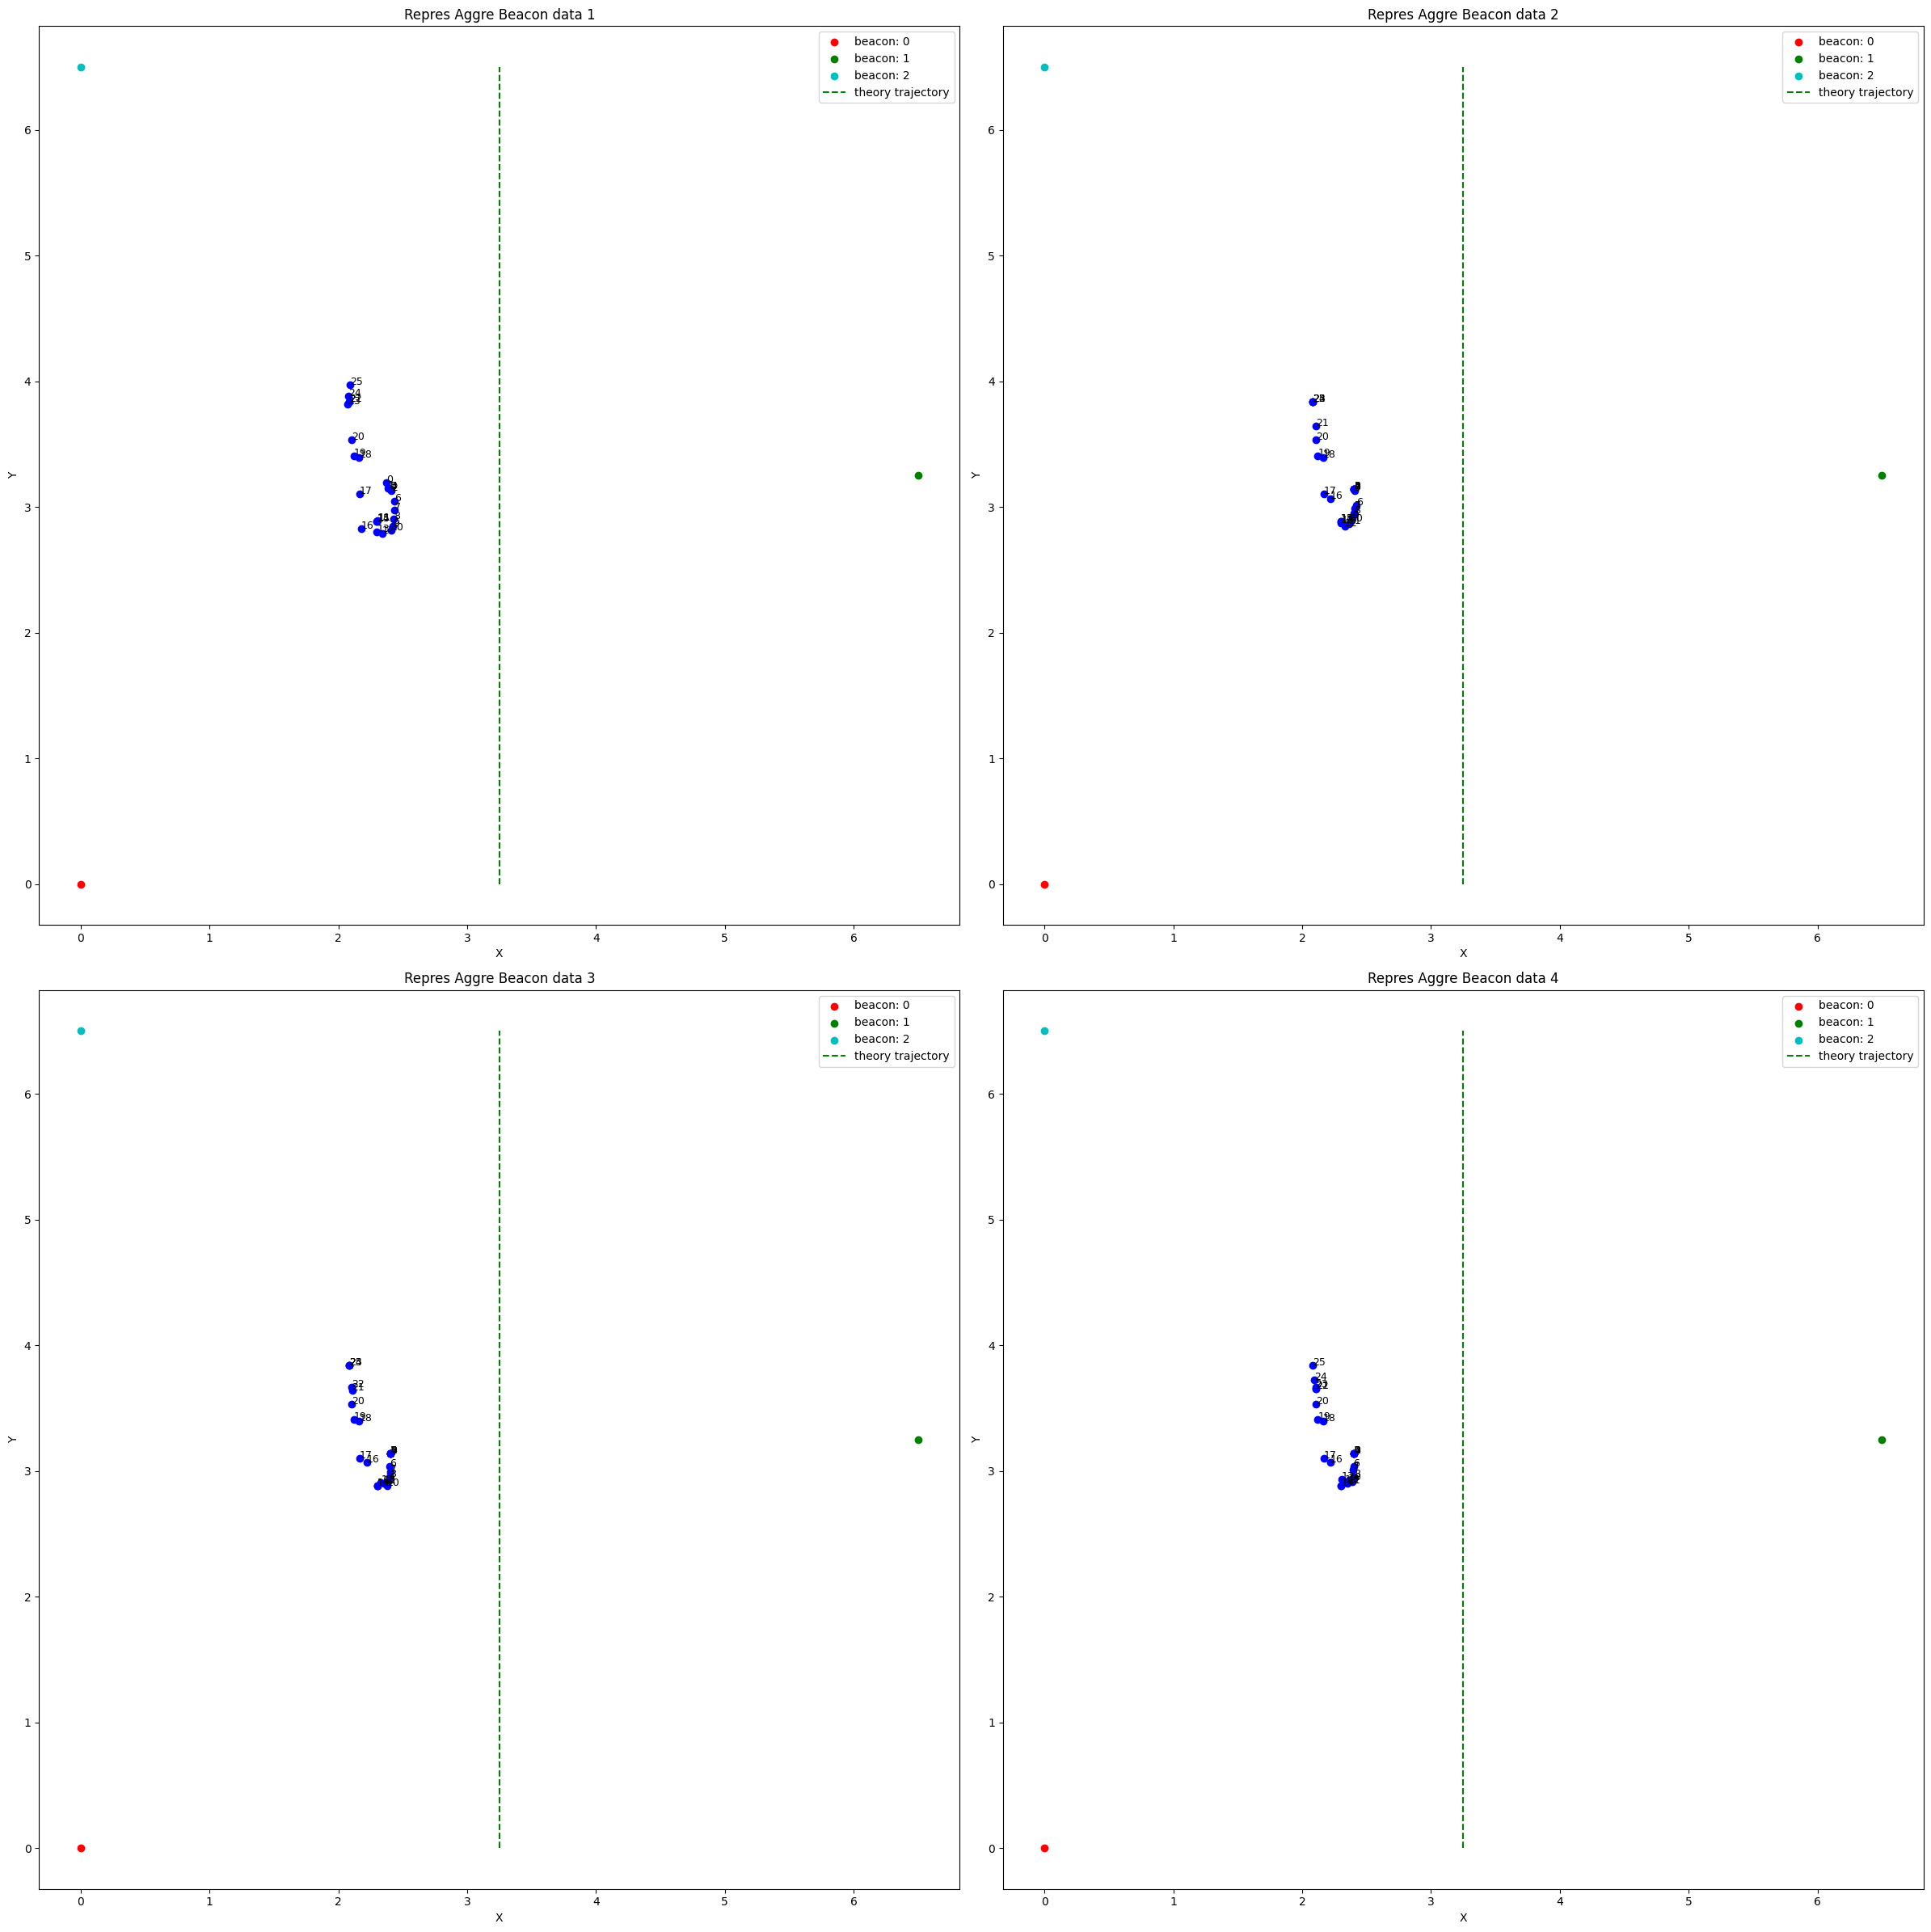

In [4]:

    
for i, positions in enumerate(positionss):
    print("len positions", len(positions))
    args.beacon_data_file = args.beacon_data_dir + beacon_data_file
    actual_coords = read_beacon_coords(args.beacon_coords_file)
    
    colors = ['r', 'g', 'c', 'm', 'y', 'k', 'b']
    plt.figure(figsize=(12, 12))
    for i,k in enumerate(actual_coords.keys()):
        plt.scatter(actual_coords[k]['x'], actual_coords[k]['y'], c=colors[i], label=f"beacon: {i}")
        
    print("positions", positions)
    for i, pos in enumerate(positions):
        if pos is None:
            continue
        plt.scatter(pos[0], pos[1], c='b')
        plt.text(pos[0], pos[1], f"{i}", fontsize=9)
        
    plt.vlines(3.25, 0, 6.5, colors='g', linestyles='dashed', label='theory trajectory')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.title(f"Beacon data: {args.beacon_data_file}")
    plt.show()

    print("positions", positions)
    
    repre_size = 8
    aggre_size = 3
    
    repre_positions = aggregate_continuous_points_sliding(positions, repre_size)
    aggre_positinons = aggregate_continuous_points(positions, aggre_size)
    repre_aggre_positions = aggregate_continuous_points_sliding(aggre_positinons, repre_size)
    aggre_repre_positions = aggregate_continuous_points(repre_positions, aggre_size)
    plt.figure(figsize=(12, 12))
    for i,k in enumerate(actual_coords.keys()):
        plt.scatter(actual_coords[k]['x'], actual_coords[k]['y'], c=colors[i], label=f"beacon: {i}")
    for i, pos in enumerate(repre_positions):
        if pos is None:
            continue
        plt.scatter(pos[0], pos[1], c='b')
        plt.text(pos[0], pos[1], f"{i}", fontsize=9)
    
    plt.vlines(3.25, 0, 6.5, colors='g', linestyles='dashed', label='theory trajectory')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.title(f"Repre Beacon data: {args.beacon_data_file}")
    plt.show()


    plt.figure(figsize=(12, 12))
    for i,k in enumerate(actual_coords.keys()):
        plt.scatter(actual_coords[k]['x'], actual_coords[k]['y'], c=colors[i], label=f"beacon: {i}")
    for i, pos in enumerate(aggre_positinons):
        if pos is None:
            continue
        plt.scatter(pos[0], pos[1], c='b')
        plt.text(pos[0], pos[1], f"{i}", fontsize=9)
    
    plt.vlines(3.25, 0, 6.5, colors='g', linestyles='dashed', label='theory trajectory')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.title(f"Aggre Beacon data: {args.beacon_data_file}")
    plt.show()
    
    plt.figure(figsize=(12, 12))
    for i,k in enumerate(actual_coords.keys()):
        plt.scatter(actual_coords[k]['x'], actual_coords[k]['y'], c=colors[i], label=f"beacon: {i}")
    for i, pos in enumerate(repre_aggre_positions):
        if pos is None:
            continue
        plt.scatter(pos[0], pos[1], c='b')
        plt.text(pos[0], pos[1], f"{i}", fontsize=9)
    plt.vlines(2.75, 0, 6.5, colors='g', linestyles='dashed', label='theory trajectory')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.title(f"Repre Aggre Beacon data: {args.beacon_data_file}")
    plt.show()
    
    plt.figure(figsize=(12, 12))
    for i,k in enumerate(actual_coords.keys()):
        plt.scatter(actual_coords[k]['x'], actual_coords[k]['y'], c=colors[i], label=f"beacon: {i}")
    for i, pos in enumerate(aggre_repre_positions):
        if pos is None:
            continue
        plt.scatter(pos[0], pos[1], c='b')
        plt.text(pos[0], pos[1], f"{i}", fontsize=9)
    plt.vlines(3.25, 0, 6.5, colors='g', linestyles='dashed', label='theory trajectory')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.title(f"Aggre Repre Beacon data: {args.beacon_data_file}")
    plt.show()
    
    repres_aggre_positions = []
    repre_num = 4
    temp_repre_positions = repre_aggre_positions
    for i in range(repre_num):
        temp_repre_positions = aggregate_continuous_points_sliding(temp_repre_positions, repre_size)
        repres_aggre_positions.append(temp_repre_positions)
    
    plt.figure(figsize=(24, 24))
    for idx, repres_aggre_pos in enumerate(repres_aggre_positions):
        plt.subplot(2, 2, idx + 1)
        for i, k in enumerate(actual_coords.keys()):
            plt.scatter(actual_coords[k]['x'], actual_coords[k]['y'], c=colors[i], label=f"beacon: {i}")
        for i, pos in enumerate(repres_aggre_pos):
            if pos is None:
                continue
            plt.scatter(pos[0], pos[1], c='b')
            plt.text(pos[0], pos[1], f"{i}", fontsize=9)
        plt.vlines(3.25, 0, 6.5, colors='g', linestyles='dashed', label='theory trajectory')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.legend()
        plt.title(f"Repres Aggre Beacon data {idx + 1}")
    plt.tight_layout()
    plt.show()
    


In [5]:
def calculate_mae(actual_coords, estimated_coords):
    actual_coords = np.array(actual_coords)
    estimated_coords = np.array(estimated_coords)
    return np.mean(np.abs(actual_coords - estimated_coords))

def calculate_rmse(actual_coords, estimated_coords):
    actual_coords = np.array(actual_coords)
    estimated_coords = np.array(estimated_coords)
    return np.sqrt(np.mean((actual_coords - estimated_coords) ** 2))

def calculate_rmse1(actual_coords, estimated_coords):
    actual_coords = np.array(actual_coords)
    estimated_coords = np.array(estimated_coords)
    distances = np.linalg.norm(actual_coords - estimated_coords, axis=1)
    return np.sqrt(np.mean((distances) ** 2))

def calculate_average_distance(actual_coords, estimated_coords):
    actual_coords = np.array(actual_coords)
    estimated_coords = np.array(estimated_coords)
    return np.mean(np.sqrt(np.sum((actual_coords - estimated_coords) ** 2, axis=1)))

v = 6.5*100//total_interval
for i, positions in enumerate(positionss):
    actual_coords = [[3.25, v*j, 0.9] for j in range(len(positions))]
    repre_positions = aggregate_continuous_points_sliding(positions, 8)
    aggre_positinons = aggregate_continuous_points(positions, 3)
    
    repre_positions = np.array(repre_positions)
    actual_coords = np.array(actual_coords)
    actual_coords = actual_coords[:,:, np.newaxis]
    
    print("shapes", np.array(actual_coords).shape, np.array(positions).shape, np.array(repre_positions).shape, np.array(aggre_positinons).shape)
    
    print("actual_coords", actual_coords[-10:])
    print("MAE for file: ", files[i])
    print("MAE for actual_coords: ", calculate_mae(actual_coords, positions))
    print("MAE for repre_positions: ", calculate_mae(actual_coords, repre_positions))
    print("RMSE for actual_coords: ", calculate_rmse(actual_coords, positions))
    print("RMSE for repre_positions: ", calculate_rmse(actual_coords, repre_positions))
    print("RMSE1 for actual_coords: ", calculate_rmse1(actual_coords, positions))
    print("RMSE1 for repre_positions: ", calculate_rmse1(actual_coords, repre_positions))
    print("Average distance for actual_coords: ", calculate_average_distance(actual_coords, positions))
    print("Average distance for repre_positions: ", calculate_average_distance(actual_coords, repre_positions))



# plt.figure(figsize=(12, 12))
# plt.plot(actual_coords[:, 0], actual_coords[:, 1], 'bo-', label='Actual Trajectory')
# plt.plot(estimated_coords[:, 0], estimated_coords[:, 1], 'ro-', label='Estimated Trajectory')
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.legend()
# plt.title('Actual vs Estimated Trajectory')
# plt.show()

shapes (89, 3, 1) (89, 3, 1) (89, 3, 1) (30, 3, 1)
actual_coords [[[3.25]
  [0.  ]
  [0.9 ]]

 [[3.25]
  [0.  ]
  [0.9 ]]

 [[3.25]
  [0.  ]
  [0.9 ]]

 [[3.25]
  [0.  ]
  [0.9 ]]

 [[3.25]
  [0.  ]
  [0.9 ]]

 [[3.25]
  [0.  ]
  [0.9 ]]

 [[3.25]
  [0.  ]
  [0.9 ]]

 [[3.25]
  [0.  ]
  [0.9 ]]

 [[3.25]
  [0.  ]
  [0.9 ]]

 [[3.25]
  [0.  ]
  [0.9 ]]]
MAE for file:  bluetoothData(102).txt
MAE for actual_coords:  1.537239504351369
MAE for repre_positions:  1.5332063442165031
RMSE for actual_coords:  2.221602621651732
RMSE for repre_positions:  2.2032321276578304
RMSE1 for actual_coords:  3.8479286149290175
RMSE1 for repre_positions:  3.8161099859714405
Average distance for actual_coords:  3.785129964860108
Average distance for repre_positions:  3.7706680409856115
shapes (76, 3, 1) (76, 3, 1) (76, 3, 1) (26, 3, 1)
actual_coords [[[3.25]
  [0.  ]
  [0.9 ]]

 [[3.25]
  [0.  ]
  [0.9 ]]

 [[3.25]
  [0.  ]
  [0.9 ]]

 [[3.25]
  [0.  ]
  [0.9 ]]

 [[3.25]
  [0.  ]
  [0.9 ]]

 [[3.25]
  [0.  

In [6]:
# # visualize the beacon RSSI to distance
# import matplotlib.pyplot as plt
# import numpy as np
# from collections import defaultdict
# import pdb


# def rssi_to_distance(rssi):
#     txPower = -55.47
#     n = 3.106
#     return 10 ** ((txPower - rssi) / (10 * n))

# beacon_id_to_rssi = defaultdict(list)
# time_stamp = []
# print(beacon_data)
# for beacon_group in beacon_data:
#     if len(beacon_group) < 3:
#         print("beacon group length is less than 3")
#         continue
#     for beacon in beacon_group:
#         beacon_id = beacon['uuid']
#         beacon_id_to_rssi[beacon_id].append(beacon['rssi'])
#     time_stamp.append(beacon['time'])

    
# for beacon_id, rssi_values in beacon_id_to_rssi.items():
#     if len(beacon_group[0]) <= 3:
#         print("beacon group length is less than 3")
#         continue
#     plt.figure(figsize=(12, 12))
#     distance = [rssi_to_distance(rssi) for rssi in rssi_values]
#     plt.plot(time_stamp, rssi_values, label='rssi to distance')
#     plt.xlabel('time(s)')
#     plt.ylabel('rssi')
#     plt.legend()
#     plt.title('beacon id: {}'.format(beacon_id))
#     plt.show()
    
#     plt.figure(figsize=(12, 12))
#     plt.plot(time_stamp, distance, label='rssi to distance')
#     plt.xlabel('time(s)')
#     plt.ylabel('distance(m)')
#     plt.title('beacon id: {}'.format(beacon_id))
#     plt.legend()
#     plt.show()
